In [1]:
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import models
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

In [3]:
original_drowsy_dataset_dir = './data/original_dataset/Drowsy'
original_nondrowsy_dataset_dir = './data/original_dataset/NonDrowsy'
manual_annotation_train_drowsy_dir = './data/manual_annotate/train/Drowsy'
manual_annotation_train_nondrowsy_dir = './data/manual_annotate/train/NonDrowsy'
manual_annotation_test_drowsy_dir = './data/manual_annotate/test/Drowsy'
manual_annotation_test_nondrowsy_dir = './data/manual_annotate/test/NonDrowsy'
manual_annotation_nondrowsy_dir = './data/manual_annotate/NonDrowsy'
train_dir = './data/manual_annotate/train80'

#### Dataset

The Driver Drowsiness Dataset (DDD) (https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/) is an extracted and cropped faces of drivers from the videos of the Real-Life Drowsiness Dataset. The frames were extracted from videos as images using VLC software. After that, the Viola-Jones algorithm has been used to extract the region of interest from captured images. The dataset on Kaggle has following properties

The dataset has the following properties :
• RGB images
• 2 classes (Drowsy & Non Drowsy)
• Size of image : 227 x 227
• More than 41,790 images in total


In [2]:
def get_file_count(folder_path):
    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    file_count = len(files)

    return file_count

In [4]:


# Get the file counts
drowsy_count = get_file_count(original_drowsy_dataset_dir)
non_drowsy_count = get_file_count(original_nondrowsy_dataset_dir)

# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [drowsy_count, non_drowsy_count]})

# Display the dataframe
display(df)


Category  Count
0      Drowsy  22348
1  Non Drowsy  19445

Drowsy folder contains around 22348 files and Non Drowsy folder contains around 19445 files. Upon further analysis it was found that there were multiple images of same person increasing the count in dataset. Also, the data set seemed to have incorrect labeling. Lot of images that seemed Non Drowsy were labeled as Drowsy. 

Hence, a concious decision was taken to manually label 10 images of each person that distinctly categorized image as drowsy and Non Drowsy.


In [5]:
# Get the file counts
train_drowsy_count = get_file_count(manual_annotation_train_drowsy_dir)
train_non_drowsy_count = get_file_count(manual_annotation_train_nondrowsy_dir)


test_drosy_count = get_file_count(manual_annotation_test_drowsy_dir)
test_nondrowsy_count = get_file_count(manual_annotation_test_nondrowsy_dir)

total_drowsy_count = train_drowsy_count + test_drosy_count
total_non_drowsy_count = train_non_drowsy_count + test_nondrowsy_count

# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [total_drowsy_count, total_non_drowsy_count]})

# Display the dataframe
display(df)

Category  Count
0      Drowsy    276
1  Non Drowsy    234

A comprehensive dataset comprising 510 images underwent manual annotation. These images are designated for training, validation, and testing purposes. They are to be divided into respective subsets for training, validation, and testing, adhering to a proportional allocation of 60%, 20%, and 20%. Given the nature of the labeling process, which involved approximately 10 images per individual, there exists a potential overlap wherein the test subset might include images of individuals previously encountered during the model's training phase. To address this and to assess the model's performance with previously unseen data, a distinct set of images, specifically those featuring individuals whose names commence with letters S through Z, has been segregated. This measure is intended to evaluate the model's generalization capabilities on novel data.

#### Drowsy Annotated Images

In [6]:
def plot_images(directory, title):

    # Get the list of image files in the directory
    image_files = os.listdir(directory)

    # Create a figure with a grid of 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # Loop through the first 4 image files
    for i in range(4):
        # Get the image file path
        image_file = os.path.join(directory, image_files[i])
        
        # Open the image using PIL
        image = Image.open(image_file)
        
        # Display the image in the corresponding subplot
        axs[i].imshow(image)
        axs[i].axis('on')
        
        # Display the label above the image
        axs[i].set_title(title, fontsize=10, pad=2)
        
        # Add grid lines to the subplot
        axs[i].grid(True)

    # Show the figure
    plt.show()


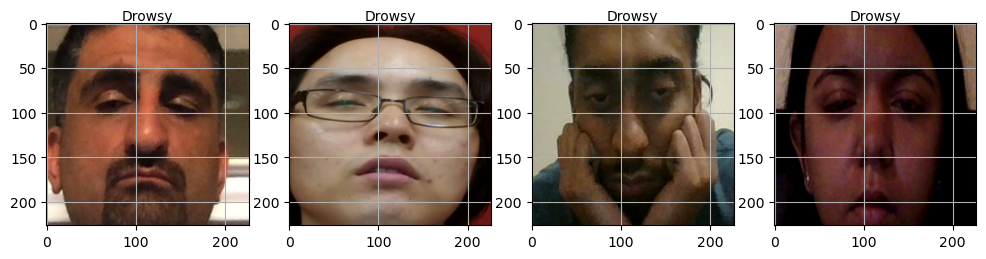

In [7]:
# Set the directory path
plot_images(directory = manual_annotation_train_drowsy_dir, title = 'Drowsy')

#### Non Drowsy Annotated Images

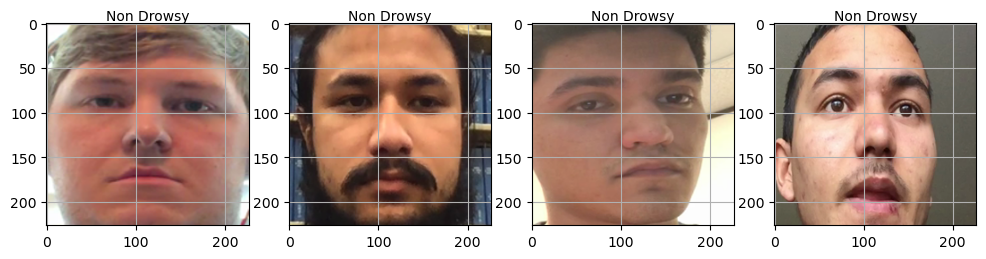

In [8]:
plot_images(directory = manual_annotation_train_nondrowsy_dir, title = 'Non Drowsy')

#### Preprocessing
The preprocessing of the image dataset will be executed through a two-stage process. Initially, the first stage will involve the random selection of 150 images each from directories labeled 'Drowsy' and 'NonDrowsy'. Selecting equal images would balance our dataset. In this phase, images from the 'Drowsy' directory will be annotated with a label of 1, while those from the 'NonDrowsy' directory will receive a label of 0, thus facilitating binary classification.

Subsequently, the second stage of preprocessing will focus on standardizing the dimensions of the images to a uniform size of 80x80 pixels. The data is split in training, validation and test set in this step. Additionally, this stage will incorporate various image augmentation techniques, including the adjustment of brightness and contrast, as well as the horizontal flipping of images. These augmented images will then be systematically incorporated into the training dataset, thereby enriching it and potentially enhancing the robustness of the model by exposing it to a more diverse range of data variations.

In [9]:
def data_preprocess_step1(train_dir, num_images=150):
    # create empty lists to store the images and their labels
    images = []
    labels = []

    # loop through each subdirectory
    for subdir in os.listdir(train_dir):
        path = os.path.join(train_dir, subdir)
        print(path)
        if os.path.isdir(path):

            # get a list of all the image files in the subdirectory
            image_files = os.listdir(path)

            # randomly select num_images images from the list
            random.seed(12356)
            np.random.seed(12356)
            selected_images = random.sample(image_files, num_images)

            # loop through the selected images
            for image_file in selected_images:
                # load the image using load_img               
                img = load_img(os.path.join(path, image_file), target_size=(80, 80))

                # convert the image to an array using img_to_array
                img_array = img_to_array(img)

                # append the image and its label to the lists
                images.append(img_array)
                
                if subdir == "Drowsy":
                    labels.append(1)
                else:
                    labels.append(0)

    # convert the images and labels to numpy arrays
    images = np.stack(images)
    labels = np.array(labels).flatten()
    return images, labels

In [10]:
def preprocess_data_step2(images, y, split=(0.8,0.2), IMAGE_SIZE=(80,80), CONTRAST_FACTOR=3, DELTA=0.3, normalize=True):
 
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1235)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val = np.split(images, [splits[0]])
    y_train, y_val = np.split(y, [splits[0]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)

    
    # rescale image to [0,1], i.e., greyscale
    if normalize:
        X_train = X_train/255.0
        X_val = X_val/255.0

     
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    #X_train_augm = tfa.image.rotate(X_train_augm, np.random.uniform(-30, 30))
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val

In [11]:
def preprocess(train_dir, normalize=True):
    # Preprocess step 1: Randomly select 150 images from 
    # the train directory and convert them to arrays
    images, y = data_preprocess_step1(train_dir, num_images=150)

    # Preprocess step 2: Split the data into training, validation, and test sets
    X_train, y_train, X_val, y_val= preprocess_data_step2(
        images, y, split=(0.8,0.2), IMAGE_SIZE=(80,80), CONTRAST_FACTOR=3, DELTA=0.3, normalize=normalize)

    print('\n----------Preprocessing Summary----------')
    print(f"images shape {images.shape}")
    print(f"y shape {y.shape}")
    print(f"X_train shape {X_train.shape}")
    print(f"y_train shape {y_train.shape}")
    print(f"X_val shape {X_val.shape}")
    print(f"y_val shape {y_val.shape}")

    print

    return X_train, y_train, X_val, y_val


#### Model
Describe model here

In [12]:
# This function builds a dynamic model for classifying drowsiness in drivers.
# It takes in various parameters to customize the architecture of the model.
def build_model_dynamic(num_conv = 2, 
                        filters = [16,16], 
                        kernel_size = [(5,5),(5,5)], 
                        strides = [(1,1),(1,1)], 
                        pool_size = [(2,2),(2,2)], 
                        pool_names = ['pool_1', 'pool_2'], 
                        conv_dropout_rate= [0.3,0.5], 
                        fc_dropout_rate = [0.5, 0, 0],
                        conv_batch_normalization = [True, True], 
                        fc_batch_normalization = [False, True, True],
                        activations = ['relu', 'relu', 'relu', 'relu', 'relu'], 
                        num_dense = 3, units = [128, 64, 32], 
                        conv_layer_names = ['conv_1', 'conv_2'],
                        fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output']):
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()

    # Loop through the specified number of convolutional layers
    for _ in range(num_conv):
        # Add a convolutional layer with the specified parameters
        model.add(layers.Conv2D(filters[_], 
                                kernel_size=kernel_size[_], 
                                strides=strides[_],
                                padding='same',
                                data_format='channels_last',
                                name=conv_layer_names[_]))
        
        # Add batch normalization if specified
        if conv_batch_normalization[_]:
            model.add(layers.BatchNormalization())

        # Add the specified activation function
        model.add(layers.Activation(activations[_]))
        
        if conv_dropout_rate[_] != 0:
            # Add dropout layer with the specified dropout rate
            model.add(layers.Dropout(conv_dropout_rate[_]))

        # Add max pooling layer with the specified pool size
        model.add(layers.MaxPooling2D(pool_size=pool_size[_], name=pool_names[_]))



    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Loop through the specified number of dense layers
    for _ in range(num_dense):
        # Add a dense layer with the specified number of units
        model.add(layers.Dense(units[_], name=fc_layer_names[_]))

        # Add batch normalization if specified
        if fc_batch_normalization[_]:
            model.add(layers.BatchNormalization())
            
        # Add the specified activation function
        model.add(layers.Activation(activations[_]))

        if fc_dropout_rate[_] != 0:
            # Add dropout layer with the specified dropout rate
            model.add(layers.Dropout(fc_dropout_rate[_]))

    # Add the final dense layer with 1 unit for binary classification
    model.add(layers.Dense(1, activation=None, name=fc_layer_names[-1]))

    # Set the random seed and build the model with the specified input shape
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    return model
    
    

    

In [13]:

def build_optimizer(learning_rate=0.001, optimizer='adam'):
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer specified.")
    return optimizer


def build_model(learning_rate=0.001, optimizer='adam'):   
    model = build_modelV2()
    model.summary()
    optimizer = build_optimizer(learning_rate, optimizer)
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                metrics=['accuracy'])
    return model


def build_model_dyn(    learning_rate=0.001, 
                        optimizer='adam', 
                        num_conv = 2, 
                        filters = [16,16], 
                        kernel_size = [(5,5),(5,5)], 
                        strides = [(1,1),(1,1)], 
                        pool_size = [(2,2),(2,2)], 
                        pool_names = ['pool_1', 'pool_2'], 
                        conv_dropout_rate= [0.3, 0.5], 
                        fc_dropout_rate = [0.5, 0, 0],
                        conv_batch_normalization = [True, True], 
                        fc_batch_normalization = [False, True, True],
                        activations = ['relu', 'relu', 'relu', 'relu', 'relu'], 
                        num_dense = 3, 
                        units = [128, 64, 32], 
                        conv_layer_names = ['conv_1', 'conv_2'],
                        fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output']):  
     
    model = build_model_dynamic(
                                num_conv=num_conv,
                                filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                pool_size=pool_size,
                                pool_names=pool_names,
                                conv_dropout_rate=conv_dropout_rate,
                                fc_dropout_rate=fc_dropout_rate,
                                conv_batch_normalization=conv_batch_normalization,
                                fc_batch_normalization=fc_batch_normalization,
                                activations=activations,
                                num_dense=num_dense,
                                units=units,
                                conv_layer_names=conv_layer_names,
                                fc_layer_names=fc_layer_names)
    
    model.summary()
    optimizer = build_optimizer(learning_rate, optimizer)
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                metrics=['accuracy'])
    
    return model



#### Baseline Accuracy 

In [14]:
def test_baseline_accuracy(model, test_dir, IMAGE_SIZE=(80,80), normalize=True):
    tf.random.set_seed(1235)
    np.random.seed(1235)

    image_test, label_test = data_preprocess_step1(test_dir, num_images=50)

    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]

    image_test = tf.image.resize(image_test, size=IMAGE_SIZE)

    if normalize:
        image_test = image_test/255.0

    test_results = model.evaluate(image_test, label_test)

    print('\n----------Baseline Model Test Results----------')
    print('\nBaseline Test Acc. {:.2f}%'.format(test_results[1]*100))
    print('-----------------------------------------------')



In [15]:
def fit_model(model, X_train, y_train, X_val, y_val, epochs=20):
    tf.random.set_seed(6666)
    np.random.seed(6666)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        epochs=epochs, 
                        validation_data=(X_val, y_val)
                        #callbacks=[early_stopping]
    )
    
    return history


In [16]:
def plot_history(history, history_plot_file = './plots/history_plot.png'):
    
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

    if history_plot_file != None:     
        fig.savefig(history_plot_file)
    


In [17]:
def evaluate_model(model, test_dir, normalize = True):

    tf.random.set_seed(1235)
    np.random.seed(1235)

    IMAGE_SIZE=(80,80)

    image_test, label_test = data_preprocess_step1(test_dir + '/', num_images=50)

    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]

    image_test = tf.image.resize(image_test, size=IMAGE_SIZE)

    if normalize:
        image_test = image_test/255.0

    test_results = model.evaluate(image_test, label_test)
    print('\n----------Model Test Accuracy Results----------')
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))
    print('-----------------------------------------------')

    return test_results[1]*100

In [18]:
def preprocess_build_train_test(train_dir, 
                                test_dir, 
                                normalize=True, 
                                learning_rate=0.001, 
                                optimizer='adam',
                                epochs=20,
                                num_conv = 2, 
                                filters = [16,16], 
                                kernel_size = [(5,5),(5,5)], 
                                strides = [(1,1),(1,1)], 
                                pool_size = [(2,2),(2,2)], 
                                pool_names = ['pool_1', 'pool_2'], 
                                conv_dropout_rate= [0.3, 0.5], 
                                fc_dropout_rate = [0.5, 0, 0],
                                conv_batch_normalization = [True, True], 
                                fc_batch_normalization = [False, True, True],
                                activations = ['relu', 'relu', 'relu', 'relu', 'relu'], 
                                num_dense = 3, 
                                units = [128, 64, 32], 
                                conv_layer_names = ['conv_1', 'conv_2'],
                                fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output'],
                                history_plot_file = './plots/history.png'):
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    X_train, y_train, X_val, y_val = preprocess(train_dir, normalize=normalize)

    model = build_model_dyn(learning_rate=learning_rate, 
                            optimizer=optimizer, 
                            num_conv=num_conv,
                            filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            pool_size=pool_size,
                            pool_names=pool_names,
                            conv_dropout_rate=conv_dropout_rate,
                            fc_dropout_rate=fc_dropout_rate,
                            conv_batch_normalization=conv_batch_normalization,
                            fc_batch_normalization=fc_batch_normalization,
                            activations=activations,
                            num_dense=num_dense,
                            units=units,
                            conv_layer_names=conv_layer_names,
                            fc_layer_names=fc_layer_names
                            )
    
    test_baseline_accuracy(model, test_dir, normalize=normalize)
    history = fit_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
    plot_history(history, history_plot_file=history_plot_file)
    test_acc = evaluate_model(model, test_dir, normalize=normalize)

    return model, test_acc

In [19]:
def get_model_size(model):
    # Calculate the size of the model
    total_model_size = 0

    for layer in model.layers:
        for weight in layer.weights:
            param_size = weight.shape.num_elements() * weight.dtype.size
            total_model_size += param_size

    total_model_size_kb = total_model_size / 1024
    total_model_size_mb = total_model_size_kb / 1024

    print(f"Model size: {total_model_size_kb:.2f} KB or {total_model_size_mb:.2f} MB")

    return total_model_size_mb


In [20]:
from itertools import product

learning_rate               =   [0.001,
                                 0.01]
 
optimizer                   =   ['adam',
                                 'adagrad', 
                                 'sgd']
                                 
                        
filters                     =   [[16,16],
                                 [16,8],
                                 [8,16], 
                                 [8,8]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)]]
                                 
 
strides                     =   [[(1,1),(1,1)], 
                                 [(2,2),(2,2)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [20, 30, 40]





In [25]:
from itertools import product

learning_rate               =   [0.001]
 
optimizer                   =   ['adam',
                                 'adagrad', 
                                 'sgd']
                                 
                        
filters                     =   [[16,16]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)]] 
                                 
 
strides                     =   [[(1,1),(1,1)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [20, 30, 40]

In [21]:
def build_permutations(lists):

    # Generate permutations of one element from each list
    all_permutations = list(product(*lists))

    # Print the permutations
    for idx, permutation in enumerate(all_permutations, start=1):
        print(f"Permutation {idx}: {permutation}")

    return all_permutations

In [22]:
data = {
            'Learning Rate': [],
            'Filters': [],
            'Kernel Size': [],
            'Strides': [],
            'optimizer': [],
            'Conv Dropout Rate': [],
            'FC Dropout Rate': [],
            'Units': [],
            'Pool Size': [],
            'Epochs': [],
            'Test Accuracy': [],
            'Model Size': [],
            'History Plot': []
        }

In [23]:
import os

def create_directory(dir_path):

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def clear_dir(directory):
    if os.path.exists(directory):
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

Permutation 36/36
./data/manual_annotate/train/NonDrowsy
./data/manual_annotate/train/Drowsy

----------Preprocessing Summary----------
images shape (300, 80, 80, 3)
y shape (300,)
X_train shape (480, 80, 80, 3)
y_train shape (480,)
X_val shape (60, 80, 80, 3)
y_val shape (60,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 80, 80, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 80, 80, 16)        0         
                                                                 
 dropout (Dropout)           (None, 80, 80, 16)        0         
                                         

./data/manual_annotate/test/NonDrowsy
./data/manual_annotate/test/Drowsy


2023-12-02 13:07:09.601453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 111ms/step - loss: 0.6929 - accuracy: 0.5000

----------Baseline Model Test Results----------

Baseline Test Acc. 50.00%
-----------------------------------------------
Epoch 1/40


2023-12-02 13:07:10.732059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/15 [=========================>....] - ETA: 0s - loss: 0.7607 - accuracy: 0.4784

2023-12-02 13:07:12.838335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 3s 91ms/step - loss: 0.7611 - accuracy: 0.4854 - val_loss: 0.6989 - val_accuracy: 0.4667
Epoch 2/40
15/15 [==============================] - 1s 54ms/step - loss: 0.7615 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4667
Epoch 3/40
15/15 [==============================] - 0s 31ms/step - loss: 0.7332 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4667
Epoch 4/40
15/15 [==============================] - 0s 31ms/step - loss: 0.7433 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.4667
Epoch 5/40
15/15 [==============================] - 0s 32ms/step - loss: 0.7316 - accuracy: 0.5167 - val_loss: 0.6922 - val_accuracy: 0.4667
Epoch 6/40
15/15 [==============================] - 0s 28ms/step - loss: 0.7220 - accuracy: 0.5000 - val_loss: 0.6913 - val_accuracy: 0.4667
Epoch 7/40
15/15 [==============================] - 0s 27ms/step - loss: 0.7299 - accuracy: 0.4792 - val_loss: 0.6908 - val_accuracy: 0.4667
Epoch 8/40
15/15 [======

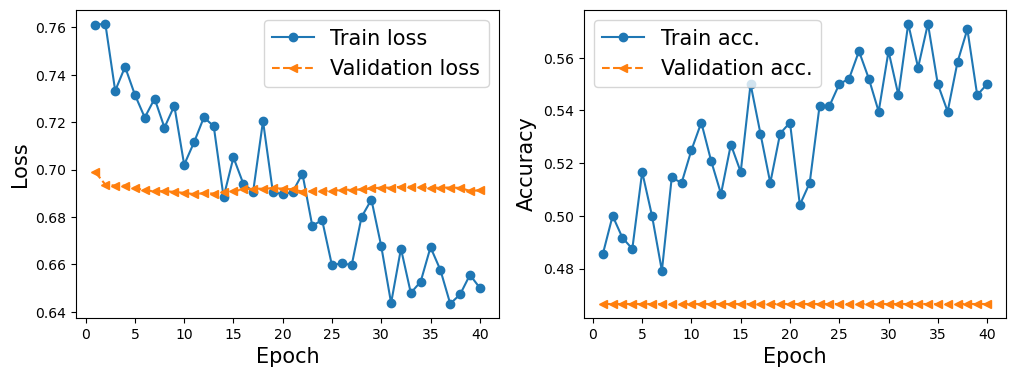

./data/manual_annotate/test/NonDrowsy
./data/manual_annotate/test/Drowsy


2023-12-02 13:07:30.898381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 113ms/step - loss: 0.7017 - accuracy: 0.5000

----------Model Test Accuracy Results----------

Test Acc. 50.00%
-----------------------------------------------
Model size: 1637.57 KB or 1.60 MB


Learning Rate   Filters       Kernel Size           Strides optimizer  \
0           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
1           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
2           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
3           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
4           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
5           0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]      adam   
6           0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
7           0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
8           0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
9           0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
10          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
11          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]      adam   
12          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
13          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
14          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
15          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
16          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
17          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]   adagrad   
18          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
19          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
20          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
21          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
22          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
23          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]   adagrad   
24          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
25          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
26          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
27          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
28          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
29          0.001  [16, 16]  [(5, 5), (5, 5)]  [(1, 1), (1, 1)]       sgd   
30          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   
31          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   
32          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   
33          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   
34          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   
35          0.001  [16, 16]  [(3, 3), (3, 3)]  [(1, 1), (1, 1)]       sgd   

   Conv Dropout Rate FC Dropout Rate          Units         Pool Size  Epochs  \
0         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      20   
1         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      30   
2         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      40   
3         [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      20   
4         [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      30   
5         [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      40   
6         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      20   
7         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      30   
8         [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      40   
9         [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      20   
10        [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      30   
11        [0.3, 0.5]     [0.5, 0, 0]   [64, 64, 32]  [(2, 2), (2, 2)]      40   
12        [0.3, 0.5]     [0.5, 0, 0]  [128, 64, 32]  [(2, 2), (2, 2)]      20   
13        [0.3, 0.5]

In [26]:
import pandas as pd
from IPython.display import clear_output, FileLink
import os

plot_dir = './plots/full_face/'
clear_dir(plot_dir)
create_directory(plot_dir)
output_file = './data/output_ff.xlsx'

model_ff_list = []

data['Learning Rate'].clear()
data['Filters'].clear()
data['Kernel Size'].clear()
data['Strides'].clear()
data['optimizer'].clear()
data['Conv Dropout Rate'].clear()
data['FC Dropout Rate'].clear()
data['Units'].clear()
data['Pool Size'].clear()
data['Epochs'].clear()
data['Test Accuracy'].clear()
data['Model Size'].clear()
data['History Plot'].clear()

lists = [learning_rate, optimizer, filters, kernel_size, strides, pool_size, conv_dropout_rate, fc_dropout_rate, conv_batch_normalization, fc_batch_normalization, activations, units, epochs]

all_permutations = build_permutations(lists)

for idx, permutation in enumerate(all_permutations, start=1):

    clear_output(wait=True)

    print (f"Permutation {idx}/{len(all_permutations)}")

    model, accuracy = preprocess_build_train_test('./data/manual_annotate/train', 
                                                  './data/manual_annotate/test', 
                                                  normalize=True, 
                                                  learning_rate=permutation[0], 
                                                  optimizer=permutation[1],
                                                  epochs=permutation[12]    ,
                                                  num_conv = 2, 
                                                  filters = permutation[2], 
                                                  kernel_size = permutation[3], 
                                                  strides = permutation[4], 
                                                  pool_size = permutation[5], 
                                                  pool_names = ['pool_1', 'pool_2'], 
                                                  conv_dropout_rate= permutation[6], 
                                                  fc_dropout_rate = permutation[7],
                                                  conv_batch_normalization = permutation[8], 
                                                  fc_batch_normalization = permutation[9],
                                                  activations = permutation[10], 
                                                  num_dense = 3, 
                                                  units = permutation[11], 
                                                  conv_layer_names = ['conv_1', 'conv_2'],
                                                  fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output'],
                                                  history_plot_file=f'{plot_dir}/history_{idx}.png')
    
    #model_ff_list.append(model)

                                                    
    data['Learning Rate'].append(permutation[0])
    data['Filters'].append(permutation[2])
    data['Kernel Size'].append(permutation[3])
    data['Strides'].append(permutation[4])
    data['optimizer'].append(permutation[1])
    data['Conv Dropout Rate'].append(permutation[6])
    data['FC Dropout Rate'].append(permutation[7])
    data['Units'].append(permutation[11])
    data['Pool Size'].append(permutation[5])
    data['Epochs'].append(permutation[12])
    data['Test Accuracy'].append(accuracy)
    data['Model Size'].append(get_model_size(model))
    data['History Plot'].append(FileLink(f'{plot_dir}/history_{idx}.png'))    

    


    df = pd.DataFrame(data)

    if idx % 5 == 0:
        if os.path.exists(output_file):
            os.remove(output_file)
        
        df.to_excel(output_file, index=False)

        display(df)
        

if os.path.exists(output_file):
    os.remove(output_file)

df.to_excel(output_file, index=False)

display(df)




#### Challenge
Despite achieving commendable levels of accuracy in both training and validation phases, the model exhibited suboptimal performance in the testing phase, as evidenced by lower test accuracy. In an effort to ameliorate this discrepancy, a series of methodical adjustments were implemented: augmenting the model architecture with additional convolutional layers, expanding the model complexity by introducing more dense layers, varying the number of filters within convolutional layers, fine-tuning the learning rate, and altering the number of training epochs. Nonetheless, these modifications failed to yield a significant improvement in the model's ability to generalize effectively to the test images.

Consequently, we shifted our focus to specifically analyzing the eye region, rather than the entire face, for drowsiness detection. To facilitate this approach, we employed external libraries, namely 'face_recognition' and 'dlib', to precisely extract the eye regions from our annotated image dataset. These cropped eye images were then utilized for the training, validation, and testing phases of our model.

#### Eye Images File Count

In [23]:

eye_train_drowsy = get_file_count('./data/cropped_1/Drowsy')
eye_train_nondrowsy = get_file_count('./data/cropped_1/NonDrowsy')
eye_test_drowsy = get_file_count('./data/test_cropped_1/Drowsy')
eye_test_nondrowsy = get_file_count('./data/test_cropped_1/NonDrowsy')

eye_drowsy_count = eye_test_drowsy + eye_train_drowsy 
eye_nondrowsy_count = eye_test_nondrowsy + eye_train_nondrowsy


# Create a dataframe
df = pd.DataFrame({'Category': ['Drowsy', 'Non Drowsy'], 'Count': [eye_drowsy_count, eye_nondrowsy_count]})

# Display the dataframe
display(df)


Category  Count
0      Drowsy    266
1  Non Drowsy    228

#### Drowsy Eye Images

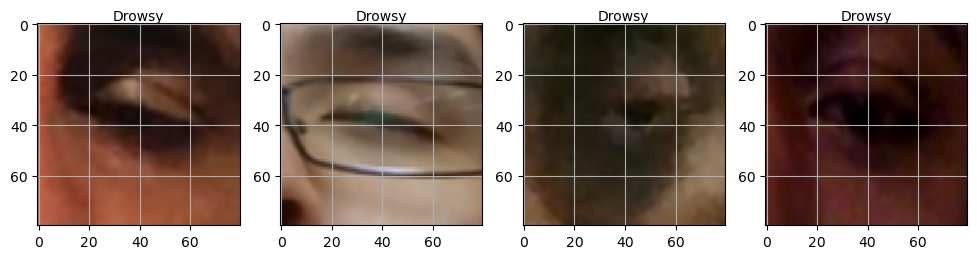

In [24]:
plot_images(directory = './data/cropped_1/Drowsy', title = 'Drowsy')

#### Non Drowsy Eye Images

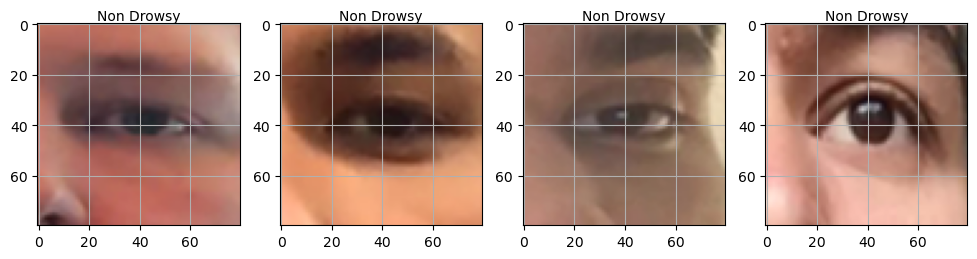

In [25]:
plot_images(directory = './data/cropped_1/NonDrowsy', title = 'Non Drowsy')

In [26]:

import pandas as pd
from IPython.display import clear_output, FileLink
import os

plot_dir = './plots/eye/'
clear_dir(plot_dir)
create_directory(plot_dir)
output_file = './data/output_eye.xlsx'

model_ff_list = []

data['Learning Rate'].clear()
data['Filters'].clear()
data['Kernel Size'].clear()
data['Strides'].clear()
data['optimizer'].clear()
data['Conv Dropout Rate'].clear()
data['FC Dropout Rate'].clear()
data['Units'].clear()
data['Pool Size'].clear()
data['Epochs'].clear()
data['Test Accuracy'].clear()
data['Model Size'].clear()
data['History Plot'].clear()

lists = [learning_rate, optimizer, filters, kernel_size, strides, pool_size, conv_dropout_rate, fc_dropout_rate, conv_batch_normalization, fc_batch_normalization, activations, units, epochs]

all_permutations = build_permutations(lists)

for idx, permutation in enumerate(all_permutations, start=1):

    clear_output(wait=True)
    
    model, accuracy = preprocess_build_train_test('./data/cropped_1/', 
                                                  './data/test_cropped_1/', 
                                                  normalize=True, 
                                                  learning_rate=permutation[0], 
                                                  optimizer=permutation[1],
                                                  epochs=permutation[12]    ,
                                                  num_conv = 2, 
                                                  filters = permutation[2], 
                                                  kernel_size = permutation[3], 
                                                  strides = permutation[4], 
                                                  pool_size = permutation[5], 
                                                  pool_names = ['pool_1', 'pool_2'], 
                                                  conv_dropout_rate= permutation[6], 
                                                  fc_dropout_rate = permutation[7],
                                                  conv_batch_normalization = permutation[8], 
                                                  fc_batch_normalization = permutation[9],
                                                  activations = permutation[10], 
                                                  num_dense = 3, 
                                                  units = permutation[11], 
                                                  conv_layer_names = ['conv_1', 'conv_2'],
                                                  fc_layer_names =['fc_1', 'fc_2', 'fc_3', 'output'],
                                                  history_plot_file=f'{plot_dir}/history_{idx}.png')
    
    #model_ff_list.append(model)

                                                    
    data['Learning Rate'].append(permutation[0])
    data['Filters'].append(permutation[2])
    data['Kernel Size'].append(permutation[3])
    data['Strides'].append(permutation[4])
    data['optimizer'].append(permutation[1])
    data['Conv Dropout Rate'].append(permutation[6])
    data['FC Dropout Rate'].append(permutation[7])
    data['Units'].append(permutation[11])
    data['Pool Size'].append(permutation[5])
    data['Epochs'].append(permutation[12])
    data['Test Accuracy'].append(accuracy)
    data['Model Size'].append(get_model_size(model))
    data['History Plot'].append(FileLink(f'{plot_dir}/history_{idx}.png'))    

    


    df = pd.DataFrame(data)

    if idx % 5 == 0:
        if os.path.exists(output_file):
            os.remove(output_file)
        
        df.to_excel(output_file, index=False)
        df.to_csv('./data/output_eye.csv', index=False)

        display(df)
        

if os.path.exists(output_file):
    os.remove(output_file)

df.to_excel(output_file, index=False)
df.to_csv('./data/output_eye.csv', index=False)

display(df)




./data/cropped_1/NonDrowsy
./data/cropped_1/Drowsy

----------Preprocessing Summary----------
images shape (300, 80, 80, 3)
y shape (300,)
X_train shape (480, 80, 80, 3)
y_train shape (480,)
X_val shape (60, 80, 80, 3)
y_val shape (60,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 40, 40, 8)         224       
                                                                 
 batch_normalization (Batch  (None, 40, 40, 8)         32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 40, 8)         0         
                                                                 
 dropout (Dropout)           (None, 40, 40, 8)         0         
                                                                 
 pool_1 (MaxPooli

./data/test_cropped_1/NonDrowsy
./data/test_cropped_1/Drowsy


2023-12-02 12:51:15.472791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 7s 1s/step - loss: 0.6936 - accuracy: 0.5000

----------Baseline Model Test Results----------

Baseline Test Acc. 50.00%
-----------------------------------------------
Epoch 1/20


2023-12-02 12:51:22.812577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.5437

2023-12-02 12:51:41.865521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 26s 903ms/step - loss: 0.7091 - accuracy: 0.5437 - val_loss: 0.6913 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 2s 152ms/step - loss: 0.7440 - accuracy: 0.5500 - val_loss: 0.6888 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 1s 42ms/step - loss: 0.7144 - accuracy: 0.5583 - val_loss: 0.6885 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 1s 56ms/step - loss: 0.7434 - accuracy: 0.5188 - val_loss: 0.6894 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 1s 38ms/step - loss: 0.7349 - accuracy: 0.5500 - val_loss: 0.6907 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 1s 49ms/step - loss: 0.7317 - accuracy: 0.5167 - val_loss: 0.6922 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 1s 36ms/step - loss: 0.7102 - accuracy: 0.5521 - val_loss: 0.6944 - val_accuracy: 0.4667
Epoch 8/20
15/15 [===

KeyboardInterrupt: 

#### Display predictions

In [27]:
# Preprocess the test images

def predict_drowsy(model, dir_path, normalize=True, num_images=50):

    image_test, label_test = data_preprocess_step1(dir_path, num_images=num_images)
    np.random.seed(1235)
    shuffle = np.random.permutation(np.arange(image_test.shape[0]))
    image_test, label_test = image_test[shuffle], label_test[shuffle]
    image_test = tf.image.resize(image_test, size=(80,80))
    if normalize:
        image_test = image_test/255.0

    # Make predictions using the trained model
    pred_logits = model.predict(image_test)
    probas = tf.sigmoid(pred_logits)
    probas = probas.numpy().flatten()*100


    # Create a figure to display the test images and their predictions
    fig = plt.figure(figsize=(10, 50))

    # Iterate over each test example
    for j, example in enumerate(image_test):
        ax = fig.add_subplot(int(len(label_test)/4),4, j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(array_to_img(example))
        
        # Determine the ground truth label and the predicted probability of being drowsy
        if label_test[j]==0:
            label='Non Drowsy'
        else:
            label='Drowsy'
        
        # Display the ground truth label and the predicted probability
        ax.text(
            0.5, -0.15, 
            'GT: {:s}\nPr(Drowsy)={:.0f}%'.format(label, probas[j]), 
            size=10, 
            color='black',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

    return image_test, label_test




data/manual_annotate/test/NonDrowsy
data/manual_annotate/test/Drowsy


2023-12-02 13:59:50.736352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 69ms/step


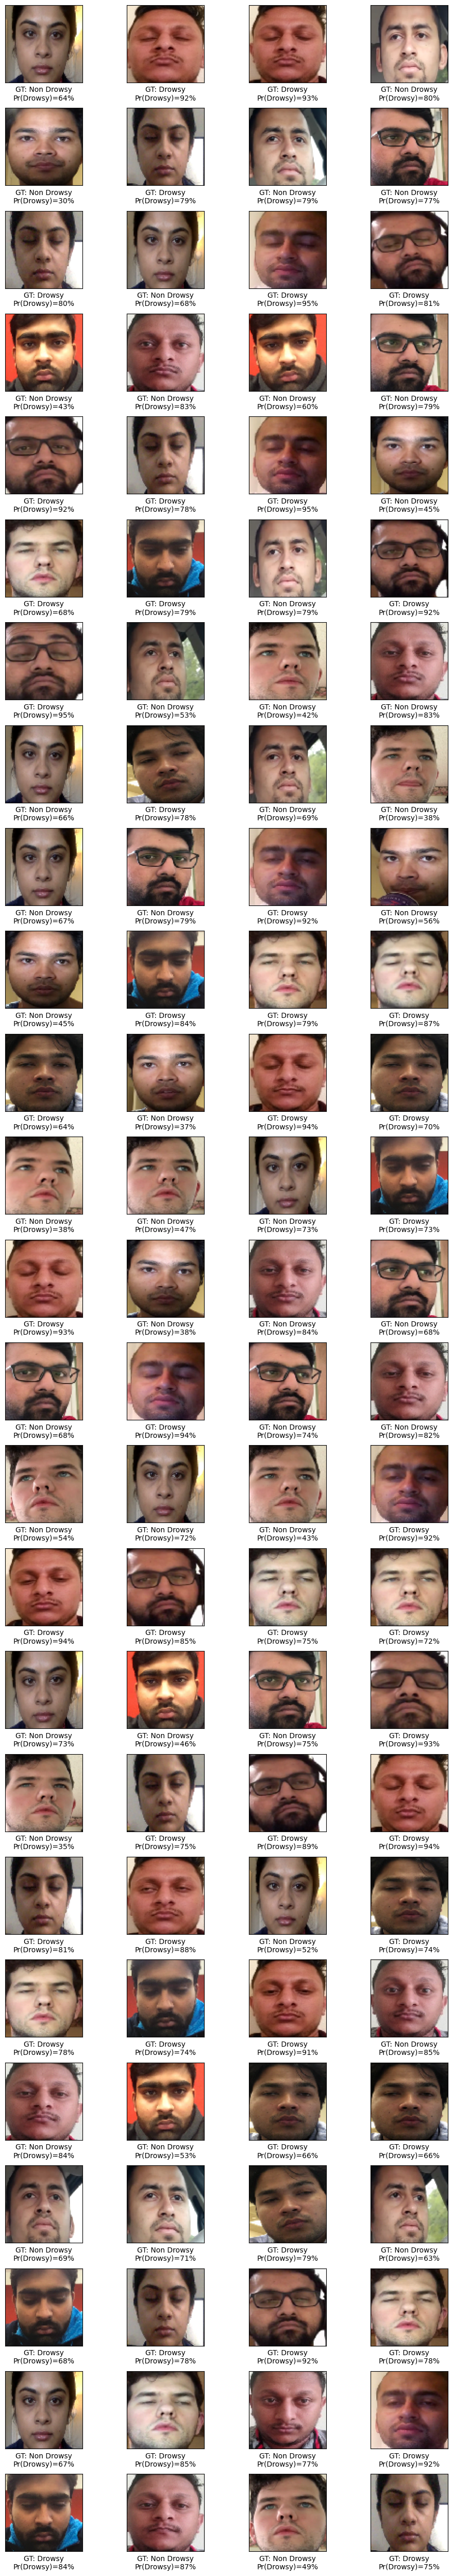

In [28]:
image_test, label_test = predict_drowsy(model_ff_list[0], 'data/manual_annotate/test/', normalize=True, num_images=50)


In [29]:
from tensorflow.keras.models import Model

def plot_filters(model, img_tensor, layer_num):

    # outputs of the first 4 layers, which include conv2D and max pooling layers
    layer_outputs = [layer.output for layer in model.layers[:layer_num]]
    activation_model = Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img_tensor)

    # grab layer names
    layer_names = []
    for layer in model.layers[:layer_num]:
        layer_names.append(layer.name)

    # getting activations of each layer
    for idx, layer in enumerate(activations):
        if idx in (0,1):
            print('----------------')
            print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
            activation = layer

            # shape of layer activation
            print('Images size is', activation.shape[1], 'x', activation.shape[2])
            print('Number of channels is', activation.shape[3])

            # print channels
            print('Printing channels:')
            
            # define nrows and ncols depending on number of channels
            if idx in (0,1):
                nrows, ncols = 4,4
            if idx in (2,3):
                nrows, ncols = 8,8

            # plots
            channel=0
            if idx in (0,1):
                f, axs = plt.subplots(nrows, ncols, figsize=(32,28))
            if idx in (2,3):
                f, axs = plt.subplots(nrows, ncols, figsize=(16,20))
                
            for i in range(nrows):
                for j in range(ncols):
                    if i==0 and j==0:
                        channel=0
                    else:
                        channel+=1

                    im = axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                    axs[i,j].set(title=str(channel))
                    plt.colorbar(im, ax=axs[i, j], fraction=0.046, pad=0.04)
                    axs[i,j].axis('on') # pay attention to the range of x and y axis
            
            plt.show()

Shape of image: (1, 80, 80, 3)


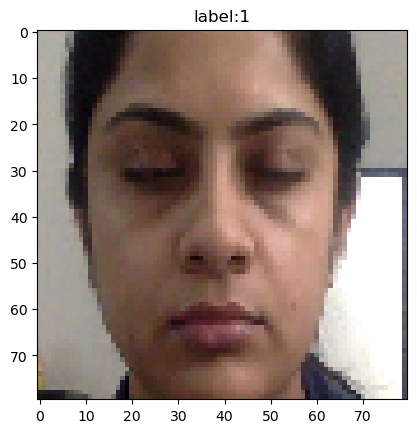

1/1 [==============================] - 0s 190ms/step


2023-12-02 14:01:01.088320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


----------------
Geeting activations of layer 1 : conv_1
Images size is 80 x 80
Number of channels is 16
Printing channels:


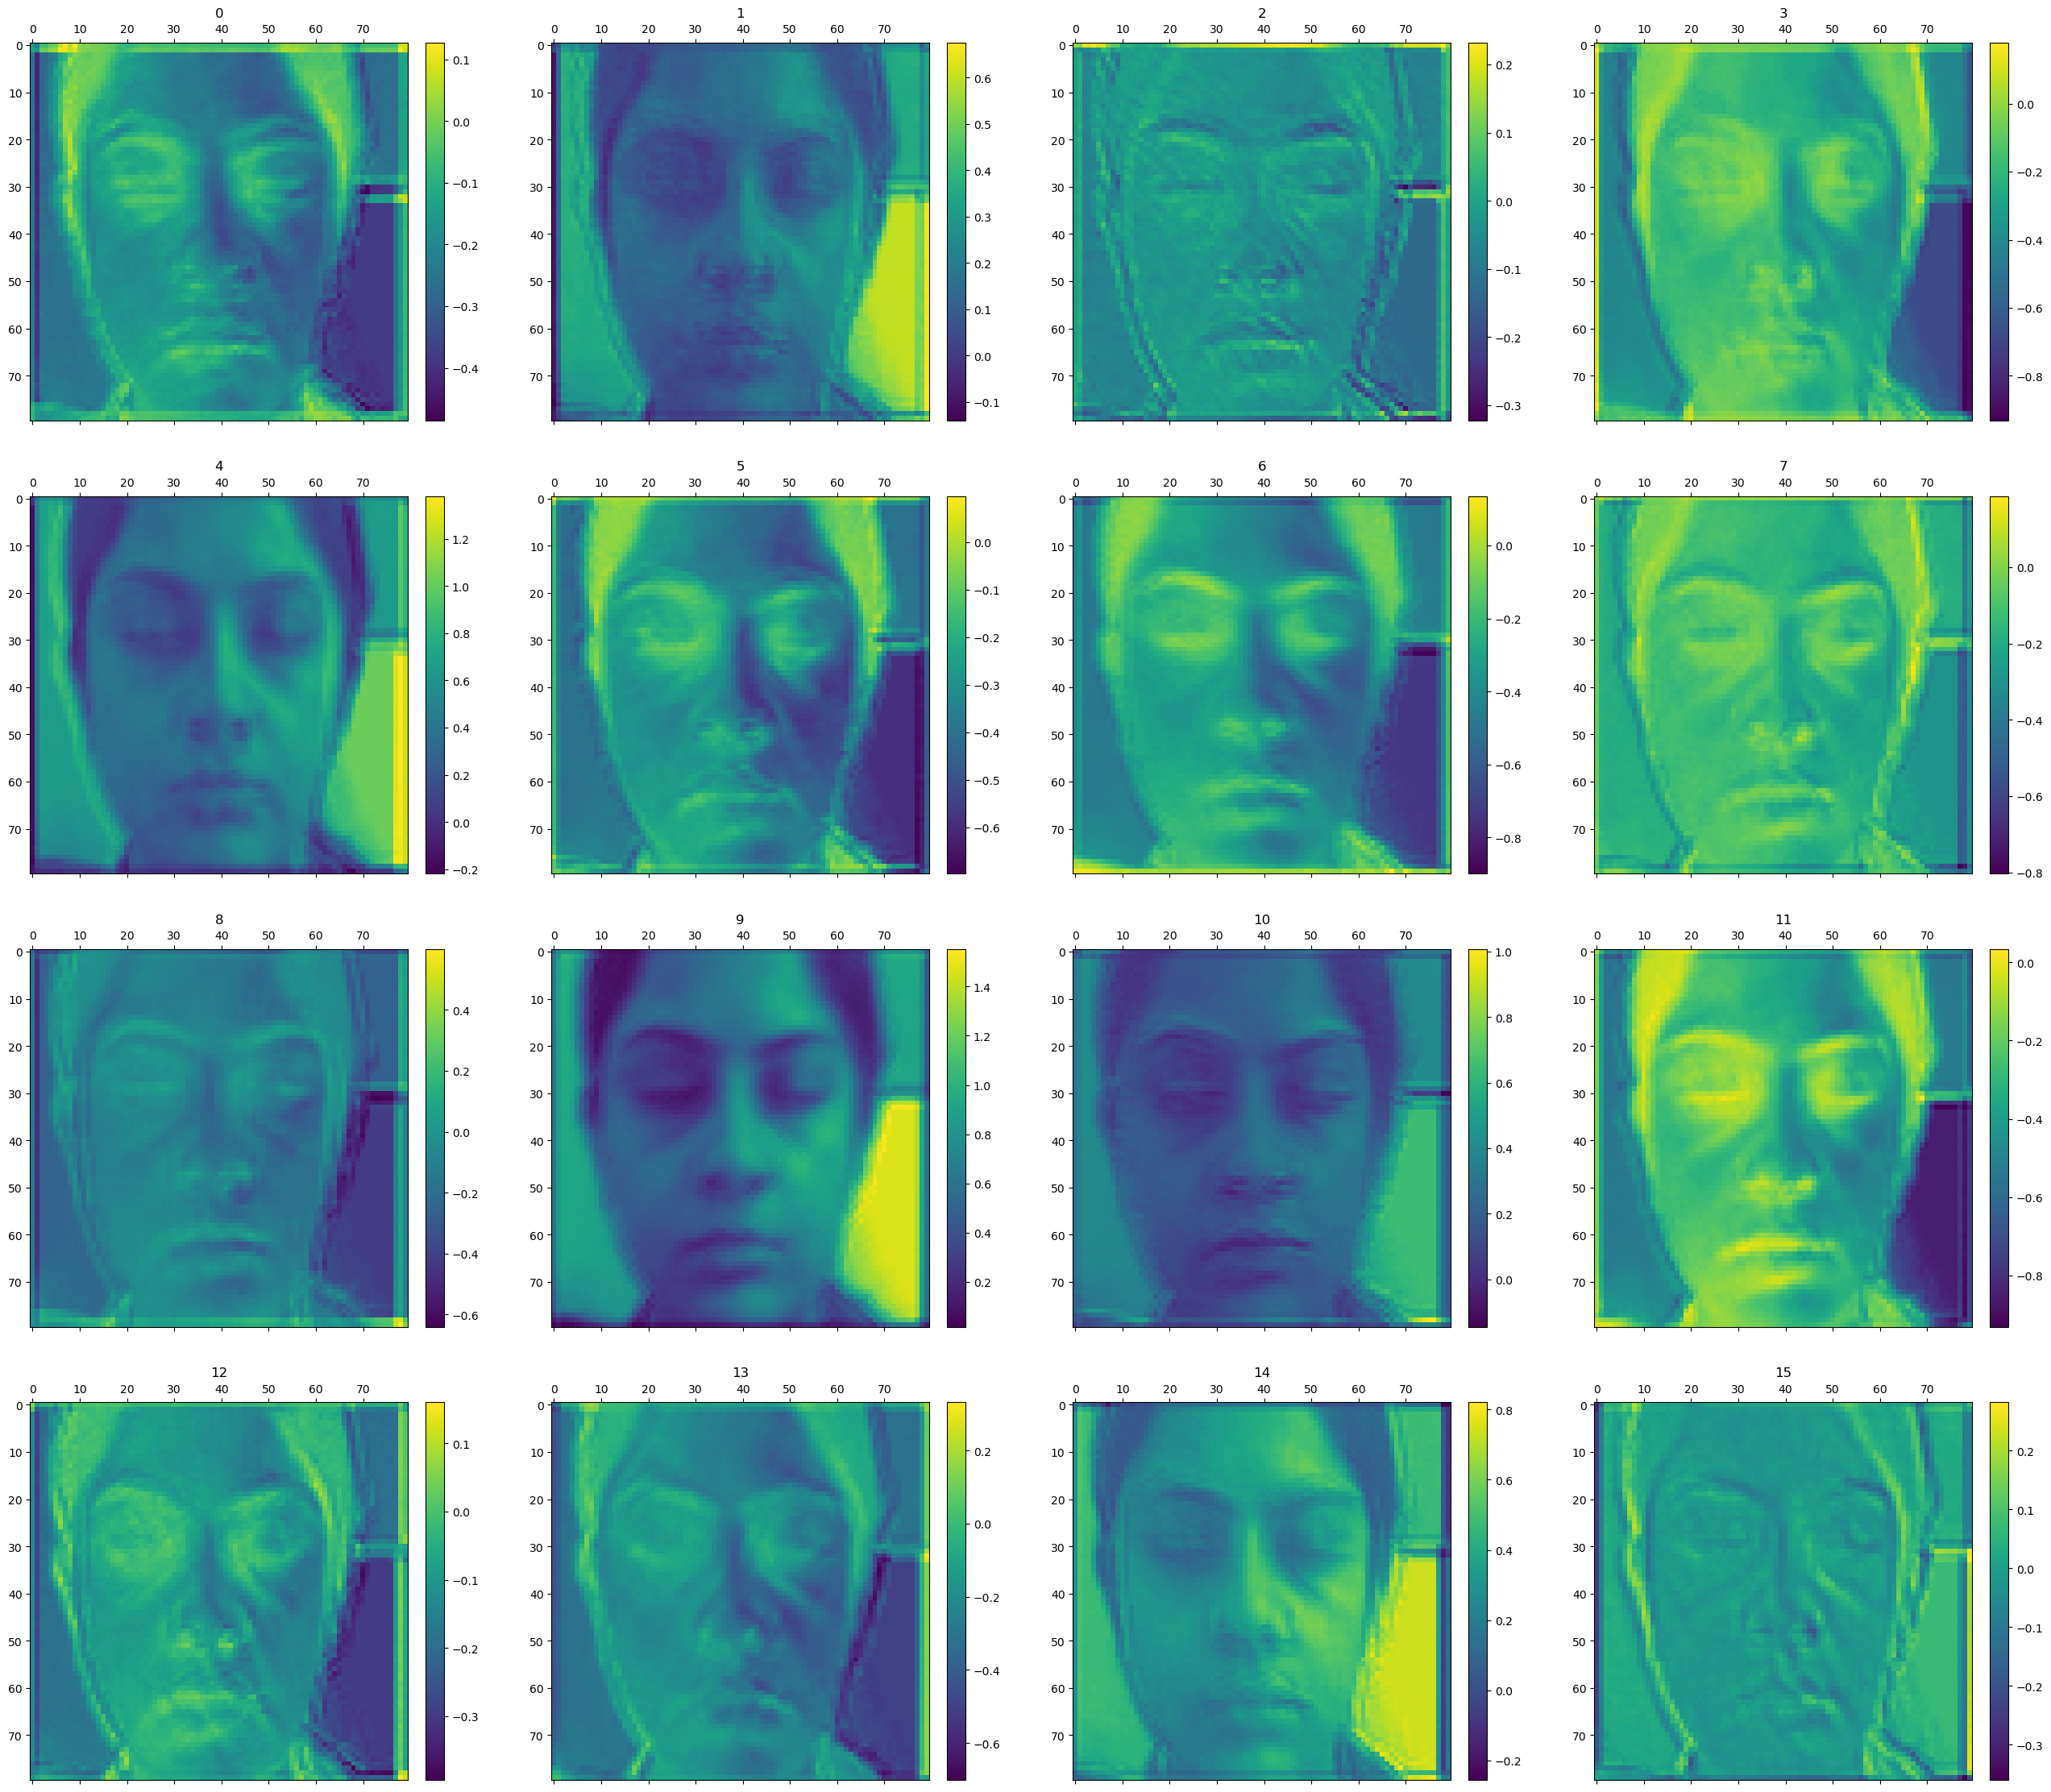

----------------
Geeting activations of layer 2 : batch_normalization
Images size is 80 x 80
Number of channels is 16
Printing channels:


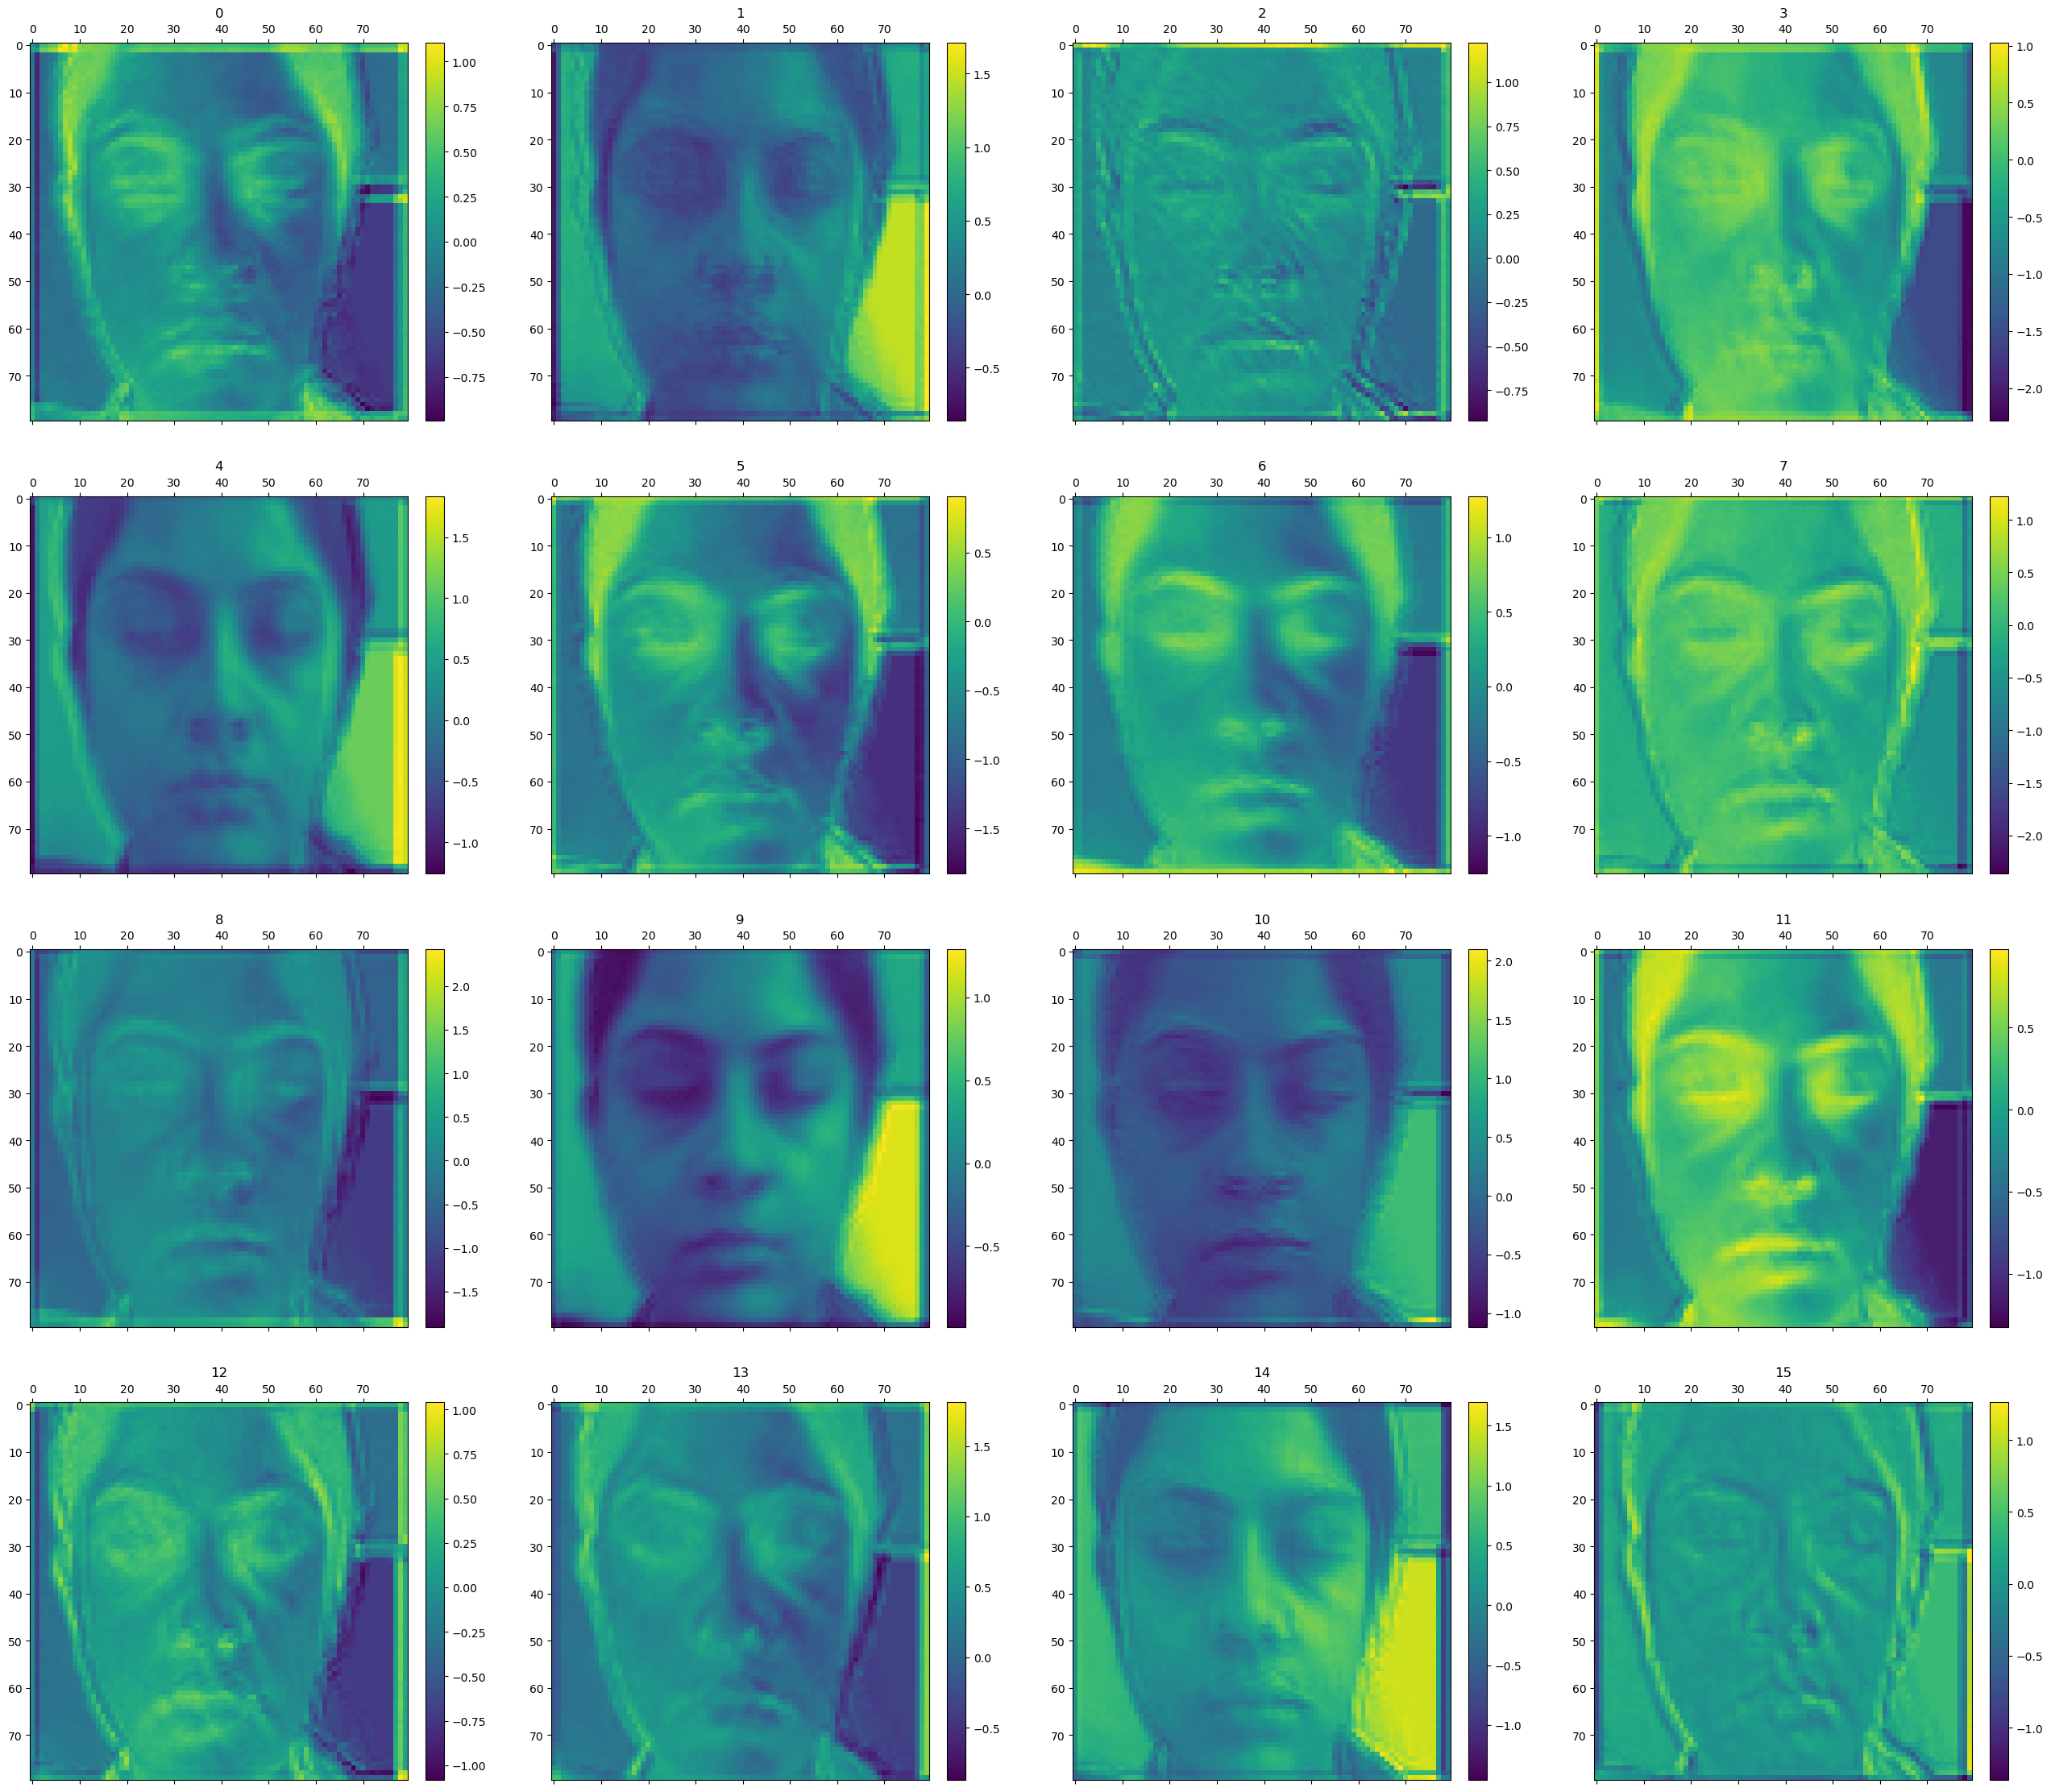

In [30]:

IMG_NUM = 5


img_tensor = np.expand_dims(image_test[IMG_NUM], axis = 0)
# Print image tensor shape
print('Shape of image:', img_tensor.shape)  
# Print image
plt.imshow(img_tensor[0])
plt.title('label:' + str(label_test[IMG_NUM]))
plt.show()

plot_filters(model_ff_list[0], img_tensor, 2)

In [31]:
# predict_drowsy('/Users/mayank/Downloads/face2/face/', normalize=True, num_images=5)
image_test, label_test = predict_drowsy(model_eye_list[4], './data/cropped_1', normalize=True, num_images=50)

NameError: name 'model_eye_list' is not defined

#### Filters Plot

In [ ]:
IMG_NUM = 5


img_tensor = np.expand_dims(image_test[IMG_NUM], axis = 0)
# Print image tensor shape
print('Shape of image:', img_tensor.shape)  
# Print image
plt.imshow(img_tensor[0])
plt.title('label:' + str(label_test[IMG_NUM]))
plt.show()



In [ ]:
plot_filters(model_eye_list[0], img_tensor, 2)

#### Additional Models Experimented

In [ ]:
def build_modelV1():
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )
    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [ ]:
def build_modelV2():
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    
    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_1'))
    
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(
        rate=0.3))
    
    
    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))
    
    
    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2'))
    
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    
    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )


    
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=128,
        name='fc_1', 
        activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))
    
    model.add(tf.keras.layers.Dense(
        units=64,
        name='fc_2'
    ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Dense(
        units=32,
        name='fc_3'
        ))
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation('relu'))
    
    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_4',
        activation=None))
    
    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))
    
    
    return model

In [ ]:
def build_modelV3():

    # Instantiate the model
    model = tf.keras.Sequential()

    # Adding first three convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu', # activation function 
                    input_shape = (80,80,3) # shape of input (image)
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Adding pooling after convolutional layers
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2))) # Dimensions of the region that you are pooling

    # Adding second set of convolutional layers
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))
    model.add(tf.keras.layers.Conv2D(
                    filters = 32, # number of filters
                    kernel_size = (3,3), # height/width of filter
                    activation = 'relu' # activation function 
                    ))

    # Add last pooling layer.
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())

    # Adding first dense layer with 256 nodes
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    # Adding a dropout layer to avoid overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3)) 

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # adding output layer
    model.add(tf.keras.layers.Dense(1, activation = None))

        # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 80, 80, 3))

    return model

#### Aditional utility function to predict images in a directory

In [ ]:
from tensorflow import keras
import pandas as pd
from IPython.display import display, Image


def predict(model, img):
    img= keras.utils.load_img(
        img, target_size=(80, 80))
    img_array = keras.utils.img_to_array(img)
    img_array = img_array/255.0
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions


dir_path = "data/manual_annotate/test/Drowsy/S0040.png"
predictions = predict(model, dir_path)
print (predictions)
'''
i = 0
file_path = []
prediction_results = []
for file_name in os.listdir(dir_path):
    
    predictions = predict(model, dir_path+file_name)
    
    print (predictions)
    
    # Convert logits to probabilities
    probabilities = tf.nn.sigmoid(predictions).numpy()
    
    prediction_results.append(probabilities[0])
    file_path.append(dir_path+file_name)



data = {'file_path': file_path, 'prediction_results': prediction_results}
df = pd.DataFrame(data)



# Display the dataframe with filepath as a link to the image
for index, row in df.iterrows():
    display(Image(filename=row['file_path']))
    print(row)


    

# Define the grid size based on the number of images
num_images = len(df)
grid_size = int(num_images ** 0.5) + 1

# Create a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

# Iterate over the dataframe rows and display the image with prediction result
for index, row in df.iterrows():
    img = plt.imread(row['file_path'])
    ax = axs[index // grid_size, index % grid_size]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Prediction: {row['prediction_results']:.2f}")

# Remove empty subplots
for i in range(num_images, grid_size ** 2):
    axs[i // grid_size, i % grid_size].axis('off')

plt.tight_layout()
plt.show()




print(np.array(prediction_results))
array = np.array(prediction_results)
print(np.size(array))

um_elements_greater_than_zero = np.sum(array > 0)

print (um_elements_greater_than_zero)

um_elements_less_than_zero = np.sum(array < 0)
print (um_elements_less_than_zero)
'''

In [ ]:
from itertools import product

learning_rate               =   [0.001,
                                 0.01]
 
optimizer                   =   ['adam',
                                 'adagrad', 
                                 'sgd']
                                 
                        
filters                     =   [[16,16],
                                 [16,8],
                                 [8,16], 
                                 [8,8]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)], 
                                 [(3,3),(5,5)], 
                                 [(5,5),(3,3)]]
 
strides                     =   [[(1,1),(1,1)], 
                                 [(2,2),(2,2)]]

pool_size                   =   [[(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0]]

conv_batch_normalization    =   [[True, True]]

fc_batch_normalization      =   [[False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [64, 64, 32]]

epochs                      =   [10, 20, 30, 40]


def build_permutations(lists):

    # Generate permutations of one element from each list
    all_permutations = list(product(*lists))

    # Print the permutations
    for idx, permutation in enumerate(all_permutations, start=1):
        print(f"Permutation {idx}: {permutation}")


    permutation = all_permutations[0]
    print(permutation[0])

lists = [learning_rate, optimizer, filters, kernel_size, strides, pool_size, conv_dropout_rate, fc_dropout_rate, conv_batch_normalization, fc_batch_normalization, activations, units, epochs]
build_permutations(lists)

In [ ]:
NUM_EXP = 5

learning_rate               =   [0.001,
                                 0.001,
                                 0.001,
                                 0.001,
                                 0.001]
 
optimizer                   =   ['adam',
                                 'adam', 
                                 'adam', 
                                 'adam',
                                 'adam']
                                 
                        
filters                     =   [[16,16],
                                 [16,16],
                                 [16,16], 
                                 [16,16],
                                 [16,16]] 

kernel_size                 =   [[(5,5),(5,5)], 
                                 [(3,3),(3,3)], 
                                 [(3,3), (5,5)], 
                                 [(5,5), (3,3)],
                                 [(5,5),(5,5)]]
 
strides                     =   [[(1,1),(1,1)], 
                                 [(1,1),(1,1)], 
                                 [(1,1),(1,1)], 
                                 [(1,1),(1,1)],
                                 [(1,1),(1,1)]]

pool_size                   =   [[(2,2),(2,2)],
                                 [(2,2),(2,2)],
                                 [(2,2),(2,2)], 
                                 [(2,2),(2,2)],
                                 [(2,2),(2,2)]]
                        
conv_dropout_rate           =   [[0.3, 0.5],
                                 [0.3, 0.5], 
                                 [0.3, 0.5], 
                                 [0.3, 0.5],
                                 [0.3, 0.5]]

fc_dropout_rate             =   [[0.5, 0, 0],
                                 [0.5, 0, 0], 
                                 [0.5, 0, 0], 
                                 [0.5, 0, 0],
                                 [0.5, 0, 0]]

conv_batch_normalization    =   [[True, True],
                                 [True, True], 
                                 [True, True], 
                                 [True, True],
                                 [True, True]]

fc_batch_normalization      =   [[False, True, True],
                                 [False, True, True], 
                                 [False, True, True], 
                                 [False, True, True],
                                 [False, True, True]]

activations                 =   [['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu'],
                                 ['relu', 'relu', 'relu', 'relu', 'relu']]
                        
units                       =   [[128, 64, 32],
                                 [128, 64, 32],
                                 [128, 64, 32],
                                 [128, 64, 32],
                                 [64, 64, 32]]